In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

save_folder = '/content/drive/MyDrive/points'
os.makedirs(save_folder, exist_ok=True)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Define the skewed Bernoulli map and its derivative
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1/b, b, b / (b - 1))


In [ ]:
def evolve_system(y, v, epsilon, b):
    N = len(y)
    y_mean = np.mean(y)
    input_y = (1 - epsilon) * y + epsilon * y_mean
    y_next = f_SB(input_y, b)

    v_mean = np.mean(v)
    input_v = (1 - epsilon) * v + epsilon * v_mean
    f_prime = df_SB(input_y, b)
    v_next = f_prime * input_v

    return y_next, v_next

def compute_lyapunov(N, b=4.0, epsilon=0.02, T_trans=2000, T_lyap=10000):
    y = np.random.rand(N).astype(np.float64)
    v = np.random.rand(N).astype(np.float64)
    v /= np.linalg.norm(v)

    # Burn-in period
    for _ in range(T_trans):
        y, v = evolve_system(y, v, epsilon, b)
        v /= np.linalg.norm(v)

    le_sum = 0.0
    for _ in range(T_lyap):
        y, v = evolve_system(y, v, epsilon, b)
        norm_v = np.linalg.norm(v)
        le_sum += np.log(norm_v)
        v /= norm_v

    return le_sum / T_lyap


In [ ]:
def compute_lyapunov_avg(args):
    N, b, epsilon, T_trans, T_lyap, trials = args
    return np.mean([
        compute_lyapunov(N, b, epsilon, T_trans, T_lyap)
        for _ in range(trials)
    ])


In [ ]:
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot


In [ ]:
def simulate_and_plot(N_list, b=4.0, epsilon=0.02, trials=5, T_trans=2000, T_lyap=10000):
    args = [(N, b, epsilon, T_trans, T_lyap, trials) for N in N_list]

    with Pool() as pool:
        lambda_list = pool.map(compute_lyapunov_avg, args)

    lambda_array = np.array(lambda_list)
    lambda_inf = np.mean(lambda_array[-3:])  # average of largest 3 N

    # ----- Plot 1: λ(N) vs 1 / ln(N) -----
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    x1 = 1 / np.log(N_list)
    y1 = lambda_array
    coeffs1 = np.polyfit(x1, y1, 1)
    y1_fit = np.polyval(coeffs1, x1)
    r2_1 = r2_score(y1, y1_fit)
    plt.plot(x1, y1, 'bo', label='Data')
    plt.plot(x1, y1_fit, 'g--', label='Fit')
    plt.xlabel('1 / ln(N)')
    plt.ylabel('λ(N)')
    plt.title(f'Logarithmic Fit\n$R^2$ = {r2_1:.4f}')
    plt.legend()

    # ----- Plot 2: ln(λ∞ - λ(N)) vs ln(N) -----
    plt.subplot(1, 2, 2)
    x2 = np.log(N_list)
    delta = np.abs(lambda_inf - lambda_array) + 1e-12
    y2 = np.log(delta)
    coeffs2 = np.polyfit(x2, y2, 1)
    y2_fit = np.polyval(coeffs2, x2)
    r2_2 = r2_score(y2, y2_fit)
    gamma = -coeffs2[0]
    plt.plot(x2, y2, 'bo', label='Data')
    plt.plot(x2, y2_fit, 'g--', label='Fit')
    plt.xlabel('ln(N)')
    plt.ylabel('ln(λ∞ - λ(N))')
    plt.title(f'Power-law Fit, γ ≈ {gamma:.2f}\n$R^2$ = {r2_2:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return lambda_array, gamma, r2_1, r2_2


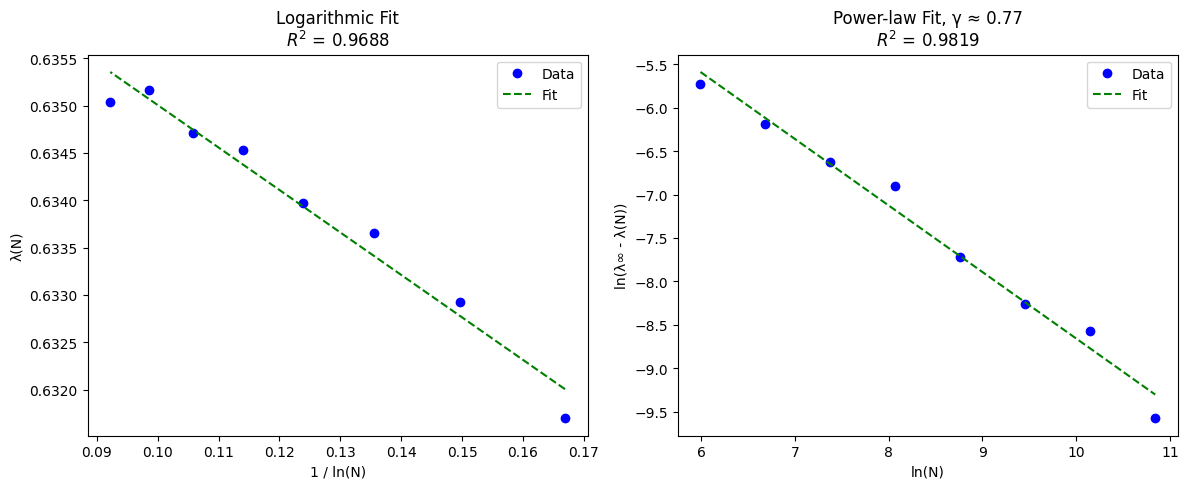

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.optimize import curve_fit
import pickle

def power_law(N, A, gamma):
    return A * N**(-gamma)

def sweep_epsilon(N_list, epsilon_list, b=4.0, trials=5, T_trans=2000, T_lyap=10000):
    lambda_inf_list = []
    gamma_list = []

    for epsilon in epsilon_list:
        print(f"Running for epsilon = {epsilon:.3f}")
        args = [(N, b, epsilon, T_trans, T_lyap, trials) for N in N_list]

        with Pool() as pool:
            lambda_list = pool.map(compute_lyapunov_avg, args)

        lambda_array = np.array(lambda_list)
        lambda_inf = np.mean(lambda_array[-3:])
        delta = np.abs(lambda_inf - lambda_array) + 1e-12

        try:
            popt, pcov = curve_fit(power_law, N_list, delta, bounds=([0, 0], [np.inf, np.inf]))
            gamma = popt[1]
            gamma_err = np.sqrt(np.diag(pcov))[1]
        except RuntimeError:
            gamma = np.nan
            gamma_err = np.nan

        lambda_inf_list.append(lambda_inf)
        gamma_list.append((gamma, gamma_err))

    lambda_inf_arr = np.array(lambda_inf_list)
    gamma_arr = np.array([g[0] for g in gamma_list])
    gamma_err_arr = np.array([g[1] for g in gamma_list])

    return np.array(epsilon_list), lambda_inf_arr, gamma_arr, gamma_err_arr


def run_sweep_save_plot(run_number, N_list, epsilon_list, b=4.0, trials=5, T_trans=2000, T_lyap=10000):
    eps_arr, lambda_arr, gamma_arr, gamma_err_arr = sweep_epsilon(
        N_list, epsilon_list, b, trials, T_trans, T_lyap)

    filename = f"run_{run_number}_data.pkl"
    save_path = f'/content/drive/MyDrive/points/{filename}'

    with open(save_path, "wb") as f:
        pickle.dump((eps_arr, lambda_arr, gamma_arr, gamma_err_arr), f)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(eps_arr, lambda_arr, marker='o')
    plt.title(f"Run {run_number}: Lambda_inf vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Lambda_inf")

    plt.subplot(1,2,2)
    plt.errorbar(eps_arr, gamma_arr, yerr=gamma_err_arr, marker='o', linestyle='-', capsize=3)
    plt.title(f"Run {run_number}: Gamma vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Gamma")

    plt.tight_layout()
    plt.show()



Running for epsilon = 0.000
Running for epsilon = 0.020
Running for epsilon = 0.041
Running for epsilon = 0.061
Running for epsilon = 0.082
Running for epsilon = 0.102
Running for epsilon = 0.122
Running for epsilon = 0.143
Running for epsilon = 0.163
Running for epsilon = 0.184
Running for epsilon = 0.204
Running for epsilon = 0.224
Running for epsilon = 0.245
Running for epsilon = 0.265
Running for epsilon = 0.286
Running for epsilon = 0.306
Running for epsilon = 0.327
Running for epsilon = 0.347
Running for epsilon = 0.367
Running for epsilon = 0.388
Running for epsilon = 0.408
Running for epsilon = 0.429
Running for epsilon = 0.449
Running for epsilon = 0.469
Running for epsilon = 0.490
Running for epsilon = 0.510
Running for epsilon = 0.531
Running for epsilon = 0.551
Running for epsilon = 0.571
Running for epsilon = 0.592
Running for epsilon = 0.612
Running for epsilon = 0.633
Running for epsilon = 0.653
Running for epsilon = 0.673
Running for epsilon = 0.694
Running for epsilon 

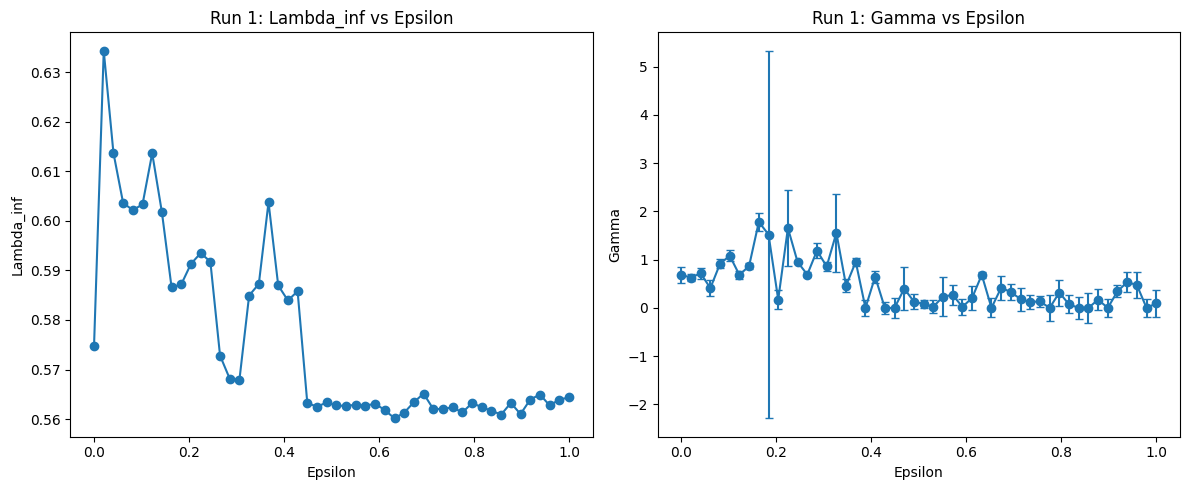

In [ ]:
# Parameters
N_list = [200, 400, 800, 1600, 3200, 6400, 12800]
epsilon_list = np.linspace(0, 1, 50)
b = 4
trials = 5
T_trans = 2000
T_lyap = 10000

run_sweep_save_plot(run_number=1, N_list=N_list, epsilon_list=epsilon_list, b=b, trials=trials, T_trans=T_trans, T_lyap=T_lyap)


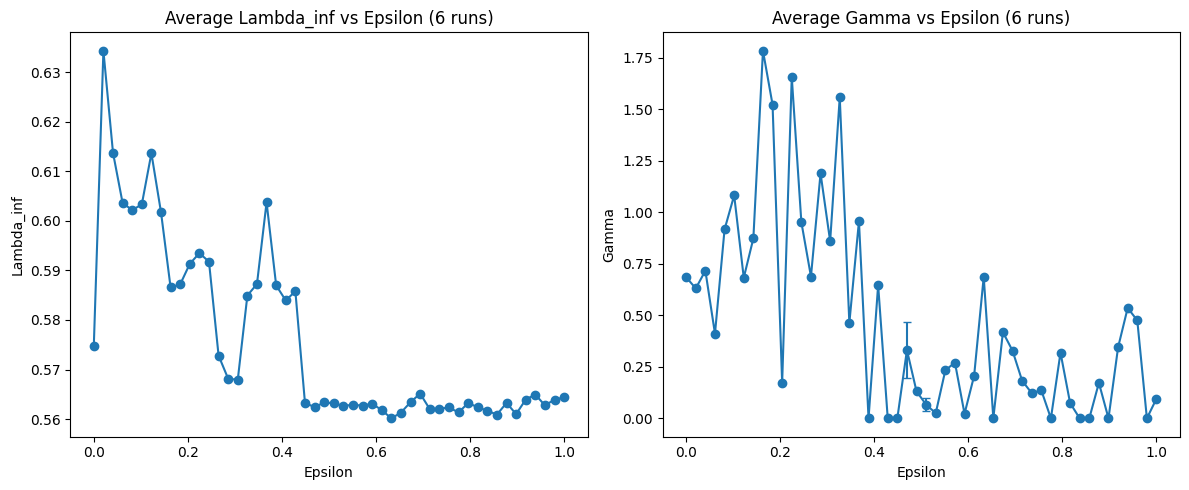

In [ ]:


import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

files = sorted(glob.glob('/content/drive/MyDrive/lyapunov_runs/run_*_data.pkl'))

all_lambda = []
all_gamma = []

for file in files:
    with open(file, "rb") as f:
        eps_arr, lambda_arr, gamma_arr, gamma_err_arr = pickle.load(f)
        all_lambda.append(lambda_arr)
        all_gamma.append(gamma_arr)

all_lambda = np.array(all_lambda)
all_gamma = np.array(all_gamma)

lambda_mean = np.nanmean(all_lambda, axis=0)
gamma_mean = np.nanmean(all_gamma, axis=0)
gamma_std = np.nanstd(all_gamma, axis=0)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(eps_arr, lambda_mean, marker='o')
plt.title("Average Lambda_inf vs Epsilon (6 runs)")
plt.xlabel("Epsilon")
plt.ylabel("Lambda_inf")

plt.subplot(1,2,2)
plt.errorbar(eps_arr, gamma_mean, yerr=gamma_std, marker='o', linestyle='-', capsize=3)
plt.title("Average Gamma vs Epsilon (6 runs)")
plt.xlabel("Epsilon")
plt.ylabel("Gamma")

plt.tight_layout()
plt.show()



Running for epsilon = 0.000
Running for epsilon = 0.005
Running for epsilon = 0.010
Running for epsilon = 0.015
Running for epsilon = 0.020
Running for epsilon = 0.025
Running for epsilon = 0.030
Running for epsilon = 0.035
Running for epsilon = 0.040
Running for epsilon = 0.045
Running for epsilon = 0.051
Running for epsilon = 0.056
Running for epsilon = 0.061
Running for epsilon = 0.066
Running for epsilon = 0.071
Running for epsilon = 0.076
Running for epsilon = 0.081
Running for epsilon = 0.086
Running for epsilon = 0.091
Running for epsilon = 0.096
Running for epsilon = 0.101
Running for epsilon = 0.106
Running for epsilon = 0.111
Running for epsilon = 0.116
Running for epsilon = 0.121


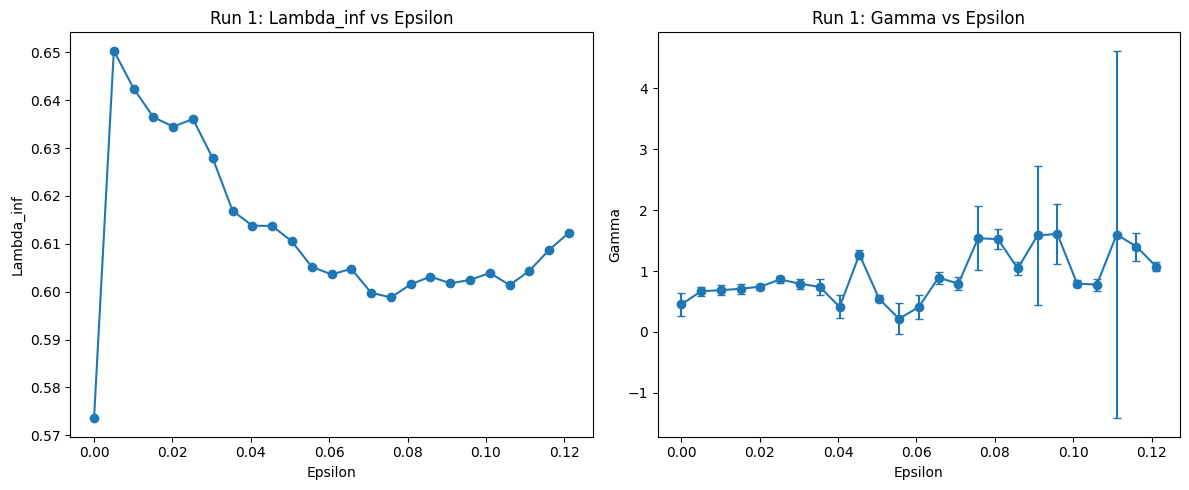

In [ ]:
N_list = [200, 400, 800, 1600, 3200, 6400, 12800]

epsilon_full = np.linspace(0, 0.5, 100)

# Split into 4 chunks manually
eps_chunk_1 = epsilon_full[:25]
eps_chunk_2 = epsilon_full[25:50]
eps_chunk_3 = epsilon_full[50:75]
eps_chunk_4 = epsilon_full[75:]

b = 4
trials = 5
T_trans = 2000
T_lyap = 10000

run_sweep_save_plot(run_number=1, N_list=N_list, epsilon_list=eps_chunk_1, b=b, trials=trials, T_trans=T_trans, T_lyap=T_lyap)

Running for epsilon = 0.126
Running for epsilon = 0.131
Running for epsilon = 0.136
Running for epsilon = 0.141
Running for epsilon = 0.146
Running for epsilon = 0.152
Running for epsilon = 0.157
Running for epsilon = 0.162
Running for epsilon = 0.167
Running for epsilon = 0.172
Running for epsilon = 0.177
Running for epsilon = 0.182
Running for epsilon = 0.187
Running for epsilon = 0.192
Running for epsilon = 0.197
Running for epsilon = 0.202
Running for epsilon = 0.207
Running for epsilon = 0.212
Running for epsilon = 0.217
Running for epsilon = 0.222
Running for epsilon = 0.227
Running for epsilon = 0.232
Running for epsilon = 0.237
Running for epsilon = 0.242
Running for epsilon = 0.247


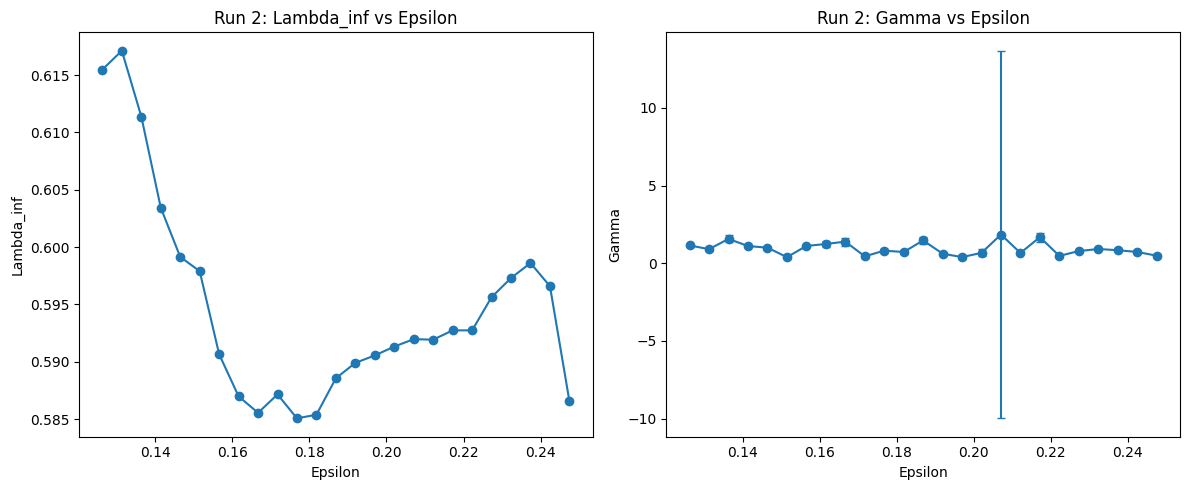

In [ ]:
run_sweep_save_plot(run_number=2, N_list=N_list, epsilon_list=eps_chunk_2, b=b, trials=trials, T_trans=T_trans, T_lyap=T_lyap)

Running for epsilon = 0.253
Running for epsilon = 0.258
Running for epsilon = 0.263
Running for epsilon = 0.268
Running for epsilon = 0.273
Running for epsilon = 0.278
Running for epsilon = 0.283
Running for epsilon = 0.288
Running for epsilon = 0.293
Running for epsilon = 0.298
Running for epsilon = 0.303
Running for epsilon = 0.308
Running for epsilon = 0.313
Running for epsilon = 0.318
Running for epsilon = 0.323
Running for epsilon = 0.328
Running for epsilon = 0.333
Running for epsilon = 0.338
Running for epsilon = 0.343
Running for epsilon = 0.348
Running for epsilon = 0.354
Running for epsilon = 0.359
Running for epsilon = 0.364
Running for epsilon = 0.369
Running for epsilon = 0.374


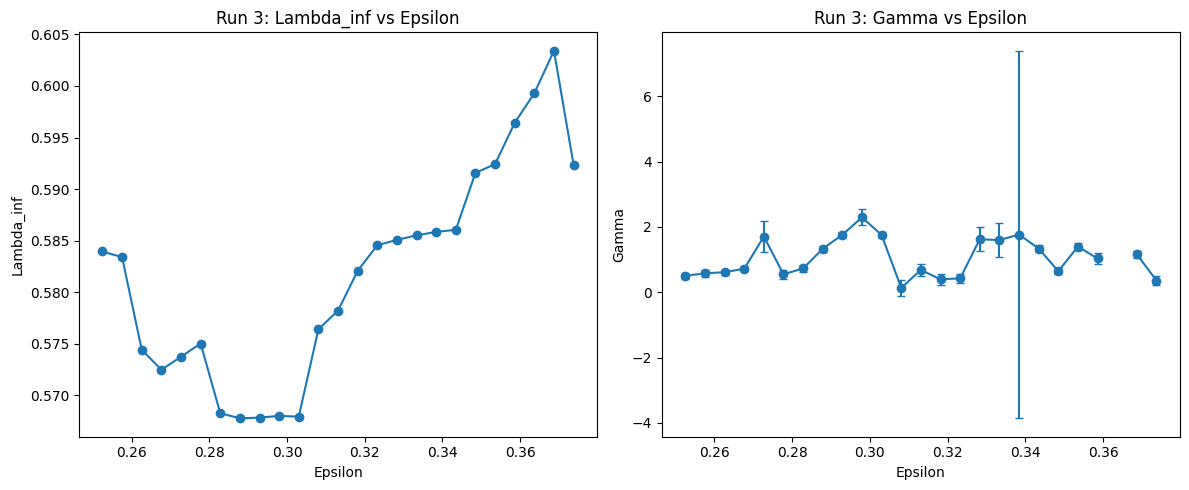

In [ ]:
run_sweep_save_plot(run_number=3, N_list=N_list, epsilon_list=eps_chunk_3, b=b, trials=trials, T_trans=T_trans, T_lyap=T_lyap)

Running for epsilon = 0.379
Running for epsilon = 0.384
Running for epsilon = 0.389
Running for epsilon = 0.394
Running for epsilon = 0.399
Running for epsilon = 0.404
Running for epsilon = 0.409
Running for epsilon = 0.414
Running for epsilon = 0.419
Running for epsilon = 0.424
Running for epsilon = 0.429
Running for epsilon = 0.434
Running for epsilon = 0.439
Running for epsilon = 0.444
Running for epsilon = 0.449
Running for epsilon = 0.455
Running for epsilon = 0.460
Running for epsilon = 0.465
Running for epsilon = 0.470
Running for epsilon = 0.475
Running for epsilon = 0.480
Running for epsilon = 0.485
Running for epsilon = 0.490
Running for epsilon = 0.495
Running for epsilon = 0.500


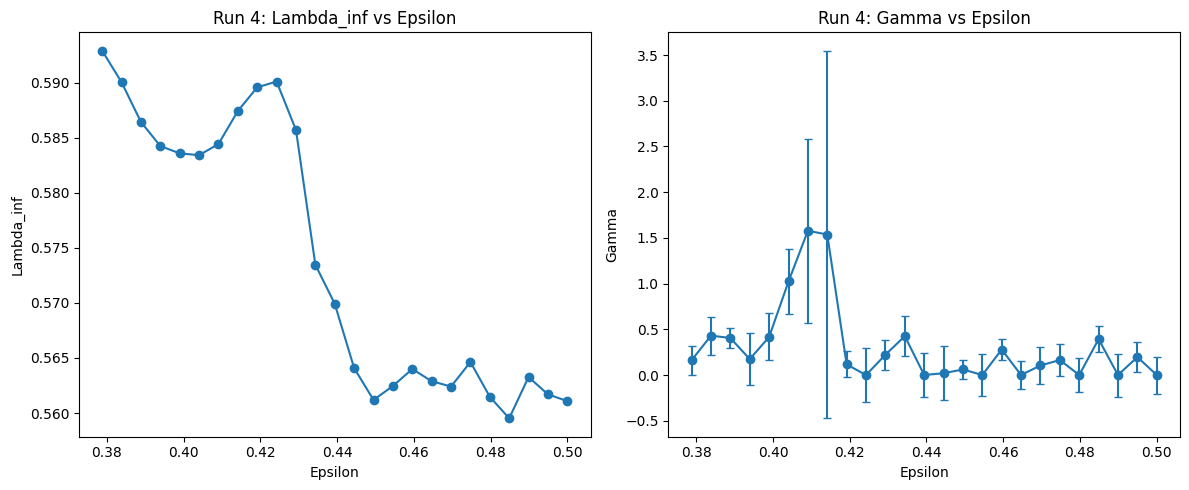

In [ ]:
run_sweep_save_plot(run_number=4, N_list=N_list, epsilon_list=eps_chunk_4, b=b, trials=trials, T_trans=T_trans, T_lyap=T_lyap)

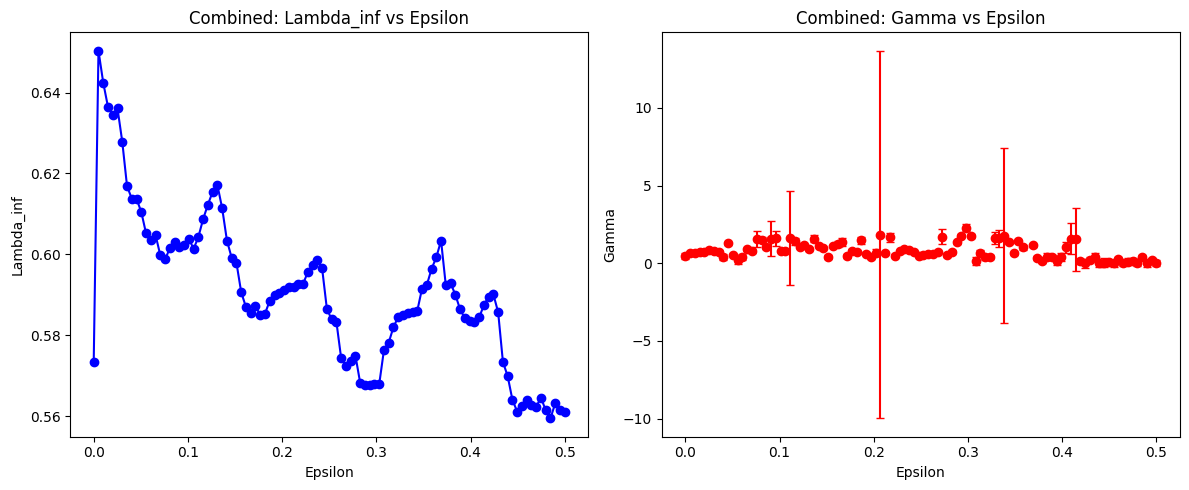

In [ ]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

# Define folder path where your run files are saved
base_path = '/content/drive/MyDrive/points/'

# Initialize lists to collect all data
eps_combined = []
lambda_combined = []
gamma_combined = []
gamma_err_combined = []

# Load all 4 run files
for run_number in range(1, 5):
    file_path = os.path.join(base_path, f'run_{run_number}_data.pkl')
    with open(file_path, 'rb') as f:
        eps_arr, lambda_arr, gamma_arr, gamma_err_arr = pickle.load(f)

    eps_combined.append(eps_arr)
    lambda_combined.append(lambda_arr)
    gamma_combined.append(gamma_arr)
    gamma_err_combined.append(gamma_err_arr)

# Concatenate and sort everything by epsilon
eps_combined = np.concatenate(eps_combined)
lambda_combined = np.concatenate(lambda_combined)
gamma_combined = np.concatenate(gamma_combined)
gamma_err_combined = np.concatenate(gamma_err_combined)

sorted_indices = np.argsort(eps_combined)
eps_sorted = eps_combined[sorted_indices]
lambda_sorted = lambda_combined[sorted_indices]
gamma_sorted = gamma_combined[sorted_indices]
gamma_err_sorted = gamma_err_combined[sorted_indices]

# Save final combined result
final_file = os.path.join(base_path, 'combined_results.pkl')
with open(final_file, 'wb') as f:
    pickle.dump((eps_sorted, lambda_sorted, gamma_sorted, gamma_err_sorted), f)

# Plot combined results
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(eps_sorted, lambda_sorted, marker='o', color='blue')
plt.title("Combined: Lambda_inf vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Lambda_inf")

plt.subplot(1,2,2)
plt.errorbar(eps_sorted, gamma_sorted, yerr=gamma_err_sorted, fmt='o', color='red', capsize=3)
plt.title("Combined: Gamma vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Gamma")

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

# Plot Lambda_inf vs Epsilon
fig_lambda = go.Figure()
fig_lambda.add_trace(go.Scatter(
    x=eps_sorted,
    y=lambda_sorted,
    mode='markers+lines',
    marker=dict(color='blue', size=6),
    name='Lambda_inf',
    hovertemplate='Epsilon: %{x}<br>Lambda_inf: %{y:.6f}<extra></extra>'
))
fig_lambda.update_layout(
    title='Combined: Lambda_inf vs Epsilon',
    xaxis_title='Epsilon',
    yaxis_title='Lambda_inf'
)

# Plot Gamma vs Epsilon with error bars
fig_gamma = go.Figure()
fig_gamma.add_trace(go.Scatter(
    x=eps_sorted,
    y=gamma_sorted,
    mode='markers+lines',
    marker=dict(color='red', size=6),
    name='Gamma',
    error_y=dict(
        type='data',
        array=gamma_err_sorted,
        visible=True,
        thickness=1.5,
        width=3
    ),
    hovertemplate='Epsilon: %{x}<br>Gamma: %{y:.6f} ± %{error_y.array}<extra></extra>'
))
fig_gamma.update_layout(
    title='Combined: Gamma vs Epsilon',
    xaxis_title='Epsilon',
    yaxis_title='Gamma'
)

# Show both plots
fig_lambda.show()
fig_gamma.show()


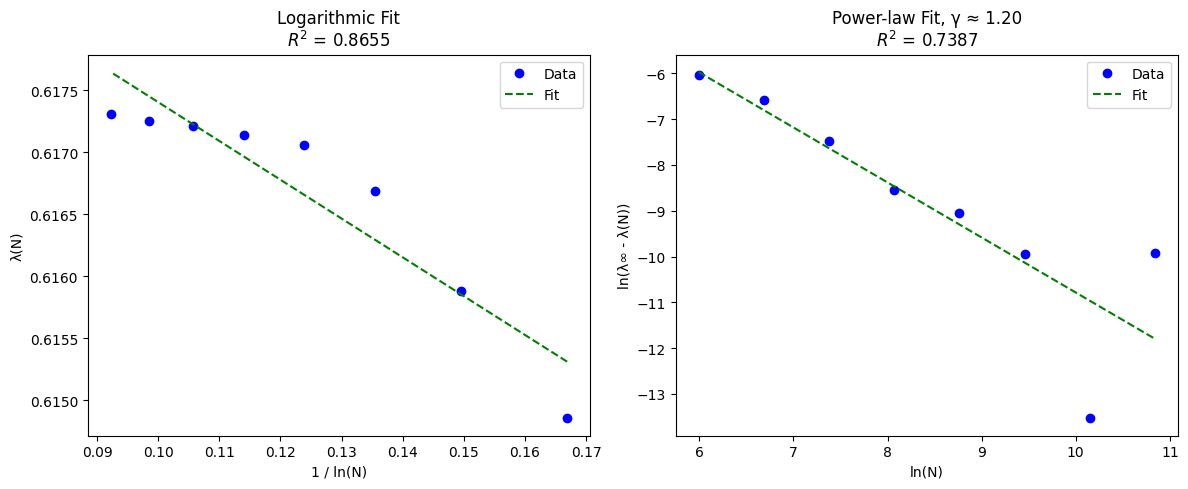

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list,b=4.0, epsilon=0.1313, trials=5, T_trans=2000, T_lyap=10000)

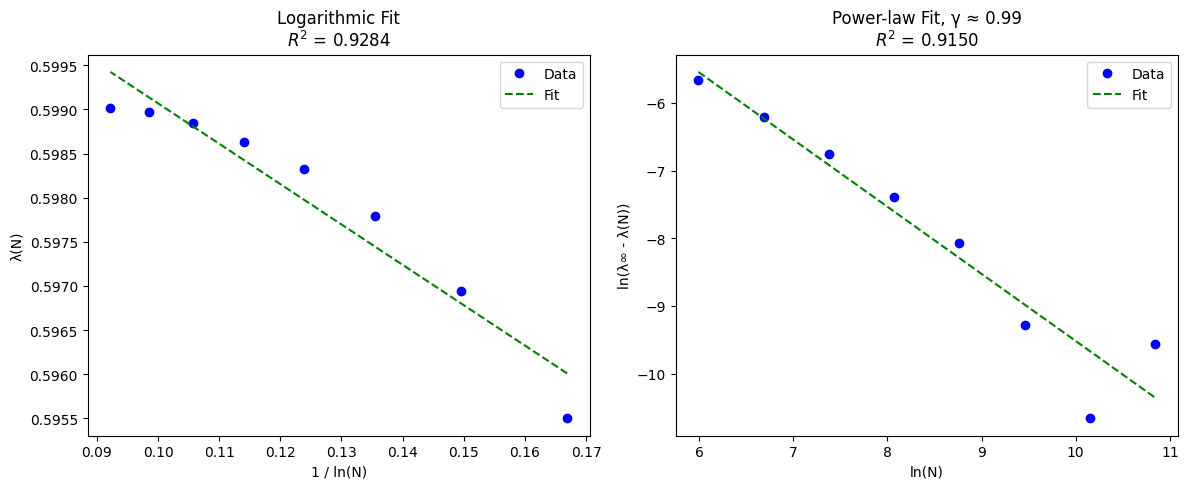

In [ ]:
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list,b=4.0, epsilon=0.2373, trials=5, T_trans=2000, T_lyap=10000)

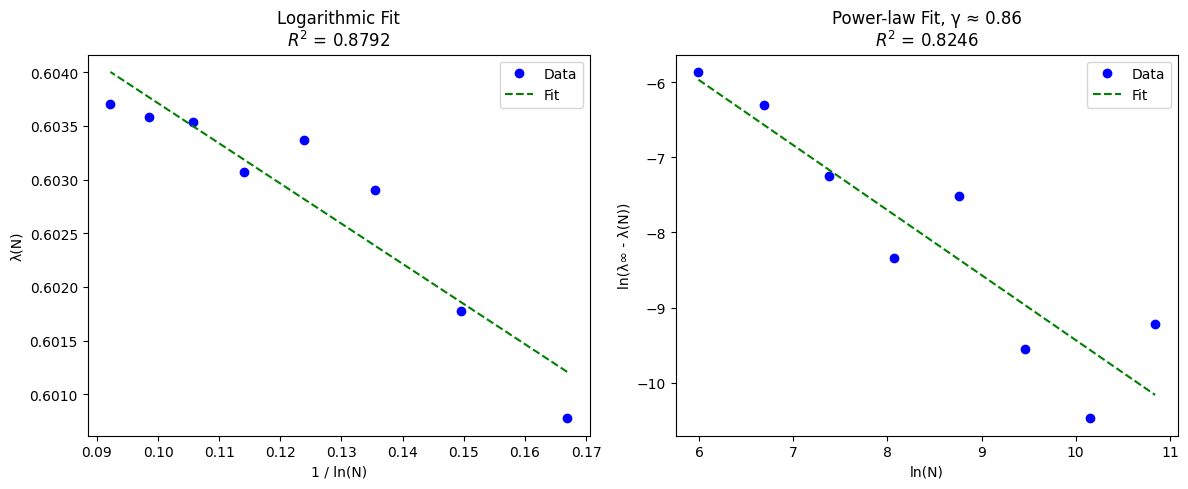

In [ ]:
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list,b=4.0, epsilon=0.3686, trials=5, T_trans=2000, T_lyap=10000)

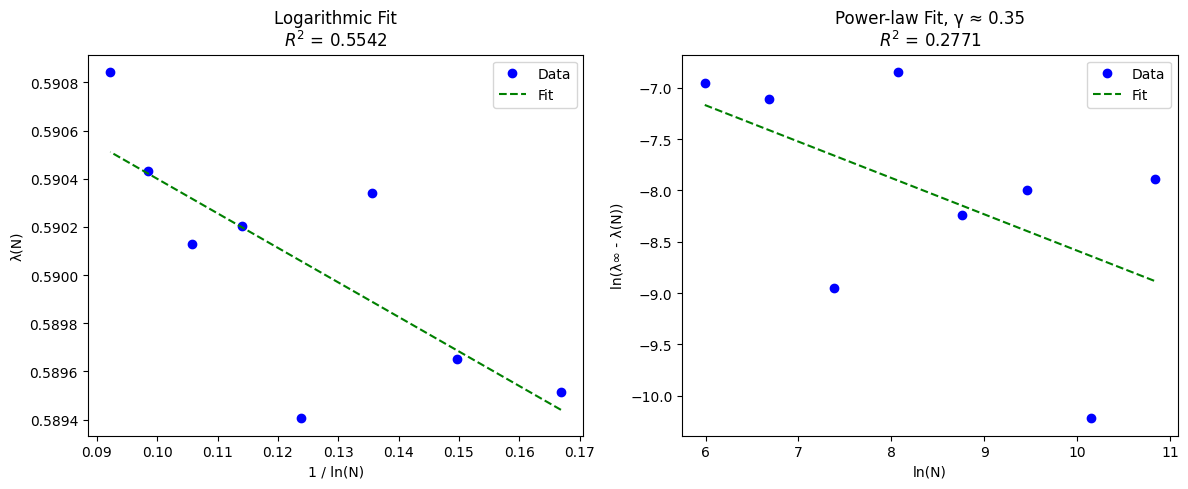

In [ ]:
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list,b=4.0, epsilon=0.4242, trials=5, T_trans=2000, T_lyap=10000)

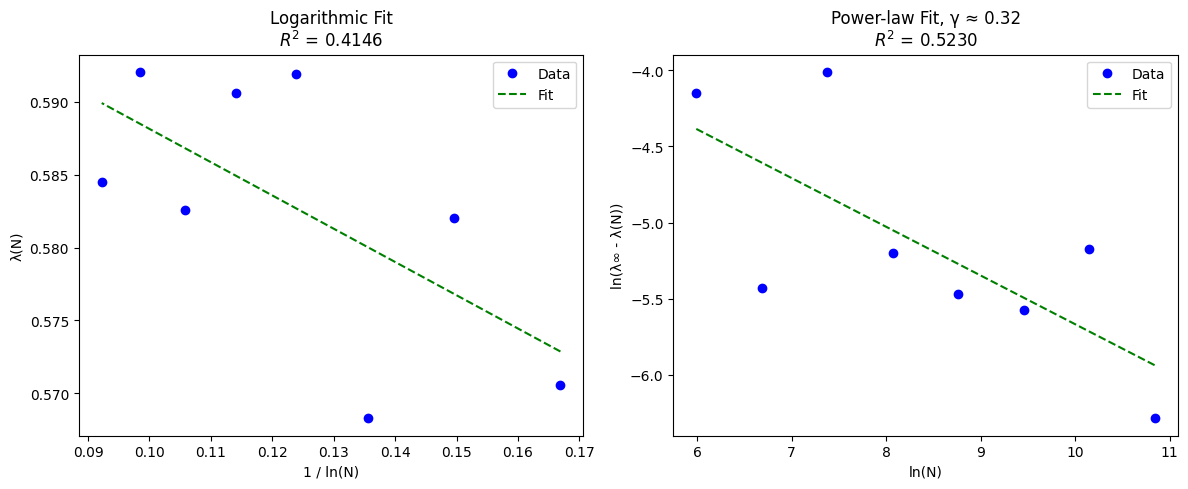

In [ ]:
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list,b=4.0, epsilon=0.43, trials=5, T_trans=2000, T_lyap=10000)

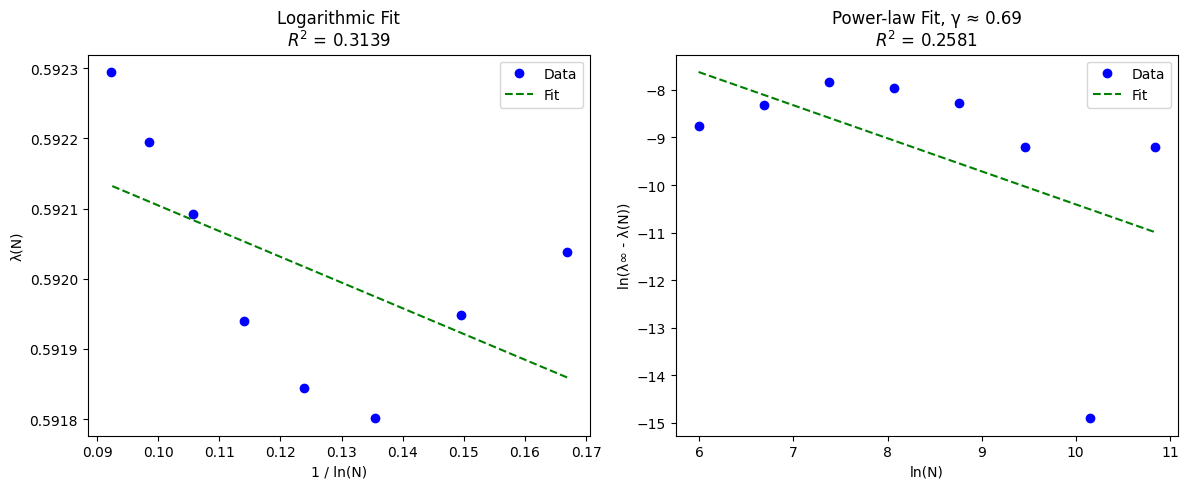

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800, 25600, 51200]
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot(N_list,b=4.0, epsilon=0.2070, trials=5, T_trans=2000, T_lyap=10000)

In [ ]:
import pandas as pd

# Load into DataFrame
df = pd.DataFrame({
    'epsilon': eps_sorted,
    'lambda': lambda_sorted,
    'gamma': gamma_sorted,
    'gamma_error': gamma_err_sorted
})

# Preview the data
print(df.head())


    epsilon    lambda     gamma  gamma_error
0  0.000000  0.573535  0.451615     0.188169
1  0.005051  0.650330  0.667885     0.075544
2  0.010101  0.642430  0.685406     0.081716
3  0.015152  0.636440  0.707698     0.083223
4  0.020202  0.634480  0.744064     0.048381


In [ ]:
from scipy.signal import find_peaks

# Detect peaks
lambda_peaks, _ = find_peaks(df['lambda'])
gamma_peaks, _ = find_peaks(df['gamma'])

# Add a column marking peak status
df['lambda_peak'] = False
df['gamma_peak'] = False
df.loc[lambda_peaks, 'lambda_peak'] = True
df.loc[gamma_peaks, 'gamma_peak'] = True

# Display peak rows
print("Lambda Peaks:\n", df[df['lambda_peak']])
print("\nGamma Peaks:\n", df[df['gamma_peak']])


Lambda Peaks:
      epsilon    lambda         gamma  gamma_error  lambda_peak  gamma_peak
1   0.005051  0.650330  6.678853e-01     0.075544         True       False
5   0.025253  0.636061  8.616962e-01     0.060139         True        True
13  0.065657  0.604770  8.920648e-01     0.098297         True        True
17  0.085859  0.603145  1.041651e+00     0.101100         True       False
20  0.101010  0.603915  7.936367e-01     0.059972         True       False
26  0.131313  0.617122  9.047752e-01     0.090832         True       False
34  0.171717  0.587159  4.428941e-01     0.119087         True       False
41  0.207071  0.591976  1.845933e+00    11.829117         True        True
43  0.217172  0.592742  1.675605e+00     0.282078         True        True
47  0.237374  0.598611  8.369689e-01     0.062129         True       False
55  0.277778  0.575031  5.514081e-01     0.137876         True       False
59  0.297980  0.568014  2.297103e+00     0.247659         True        True
73  0.3686

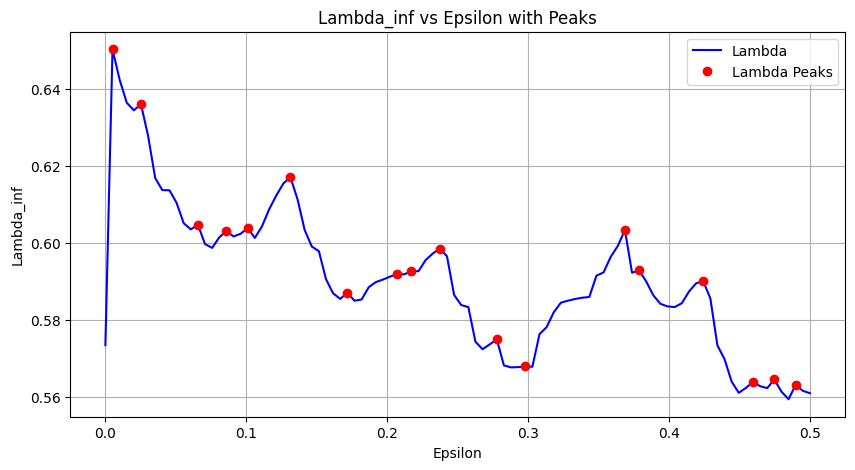

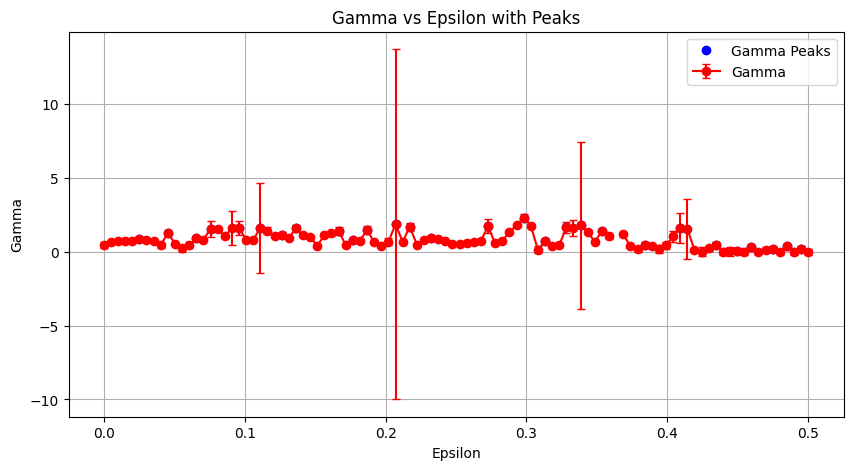

In [ ]:
# Plot lambda with peaks
plt.figure(figsize=(10, 5))
plt.plot(df['epsilon'], df['lambda'], label='Lambda', color='blue')
plt.plot(df['epsilon'][df['lambda_peak']], df['lambda'][df['lambda_peak']], 'ro', label='Lambda Peaks')
plt.title('Lambda_inf vs Epsilon with Peaks')
plt.xlabel('Epsilon')
plt.ylabel('Lambda_inf')
plt.legend()
plt.grid(True)
plt.show()

# Plot gamma with error bars and peaks
plt.figure(figsize=(10, 5))
plt.errorbar(df['epsilon'], df['gamma'], yerr=df['gamma_error'], fmt='-o', color='red', capsize=3, label='Gamma')
plt.plot(df['epsilon'][df['gamma_peak']], df['gamma'][df['gamma_peak']], 'bo', label='Gamma Peaks')
plt.title('Gamma vs Epsilon with Peaks')
plt.xlabel('Epsilon')
plt.ylabel('Gamma')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def compute_synchrony_r(y_history):
    """
    Compute r(t) = | (1/N) * sum_j exp(2πi * x_j(t)) | for all t
    Input:
        y_history: shape (T, N) — simulation history of all oscillators
    Output:
        r_values: shape (T,) — synchrony at each time step
    """
    r_values = np.abs(np.mean(np.exp(2j * np.pi * y_history), axis=1))
    return r_values


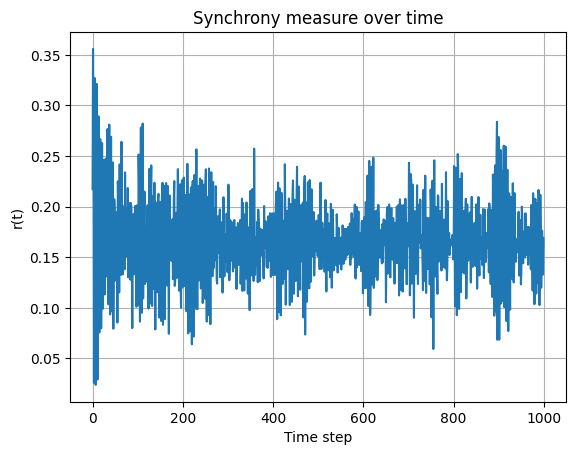

In [ ]:
# Simulate trajectories
y_history = simulate_y_trajectories(N=100, T=1000, epsilon=0.4, b=4.0)

# Compute synchrony
r_vals = compute_synchrony_r(y_history)

# Plot
import matplotlib.pyplot as plt
plt.plot(r_vals)
plt.xlabel("Time step")
plt.ylabel("r(t)")
plt.title("Synchrony measure over time")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_y_trajectories(N=100, T=1000, epsilon=0.3, b=4.0):
    y = np.random.rand(N)
    y_history = np.zeros((T, N))

    for t in range(T):
        y_mean = np.mean(y)
        input_y = (1 - epsilon) * y + epsilon * y_mean
        y = f_SB(input_y, b)
        y_history[t] = y

    return y_history

def compute_synchrony_r(y_history):
    return np.abs(np.mean(np.exp(2j * np.pi * y_history), axis=1))

def sweep_synchrony(epsilon_list, N=100, T=1000, b=4.0):
    num_eps = len(epsilon_list)
    ncols = 5
    nrows = int(np.ceil(num_eps / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 2.5), sharey=True)
    axes = axes.flatten()

    for idx, epsilon in enumerate(epsilon_list):
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=epsilon, b=b)
        r_vals = compute_synchrony_r(y_hist)

        ax = axes[idx]
        ax.plot(r_vals, color='blue')
        ax.set_title(f"ε = {epsilon:.4f}")
        ax.set_xlabel("t")
        if idx % ncols == 0:
            ax.set_ylabel("r(t)")
        ax.grid(True)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Synchrony r(t) over different ε values", y=1.02, fontsize=16)
    plt.show()


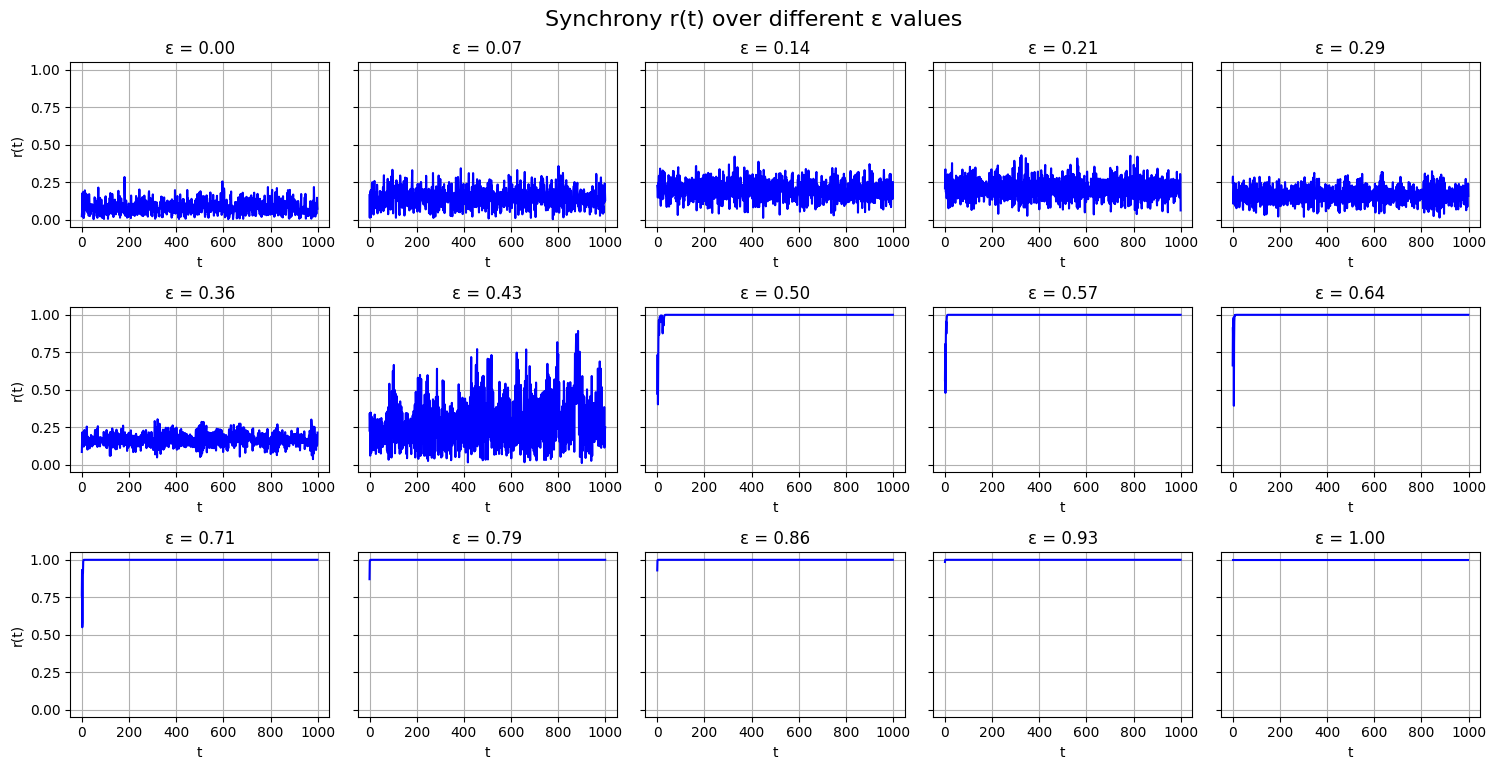

In [ ]:
epsilon_list = np.linspace(0, 1, 15)  # 15 epsilon values from 0 to 1
sweep_synchrony(epsilon_list, N=100, T=1000)


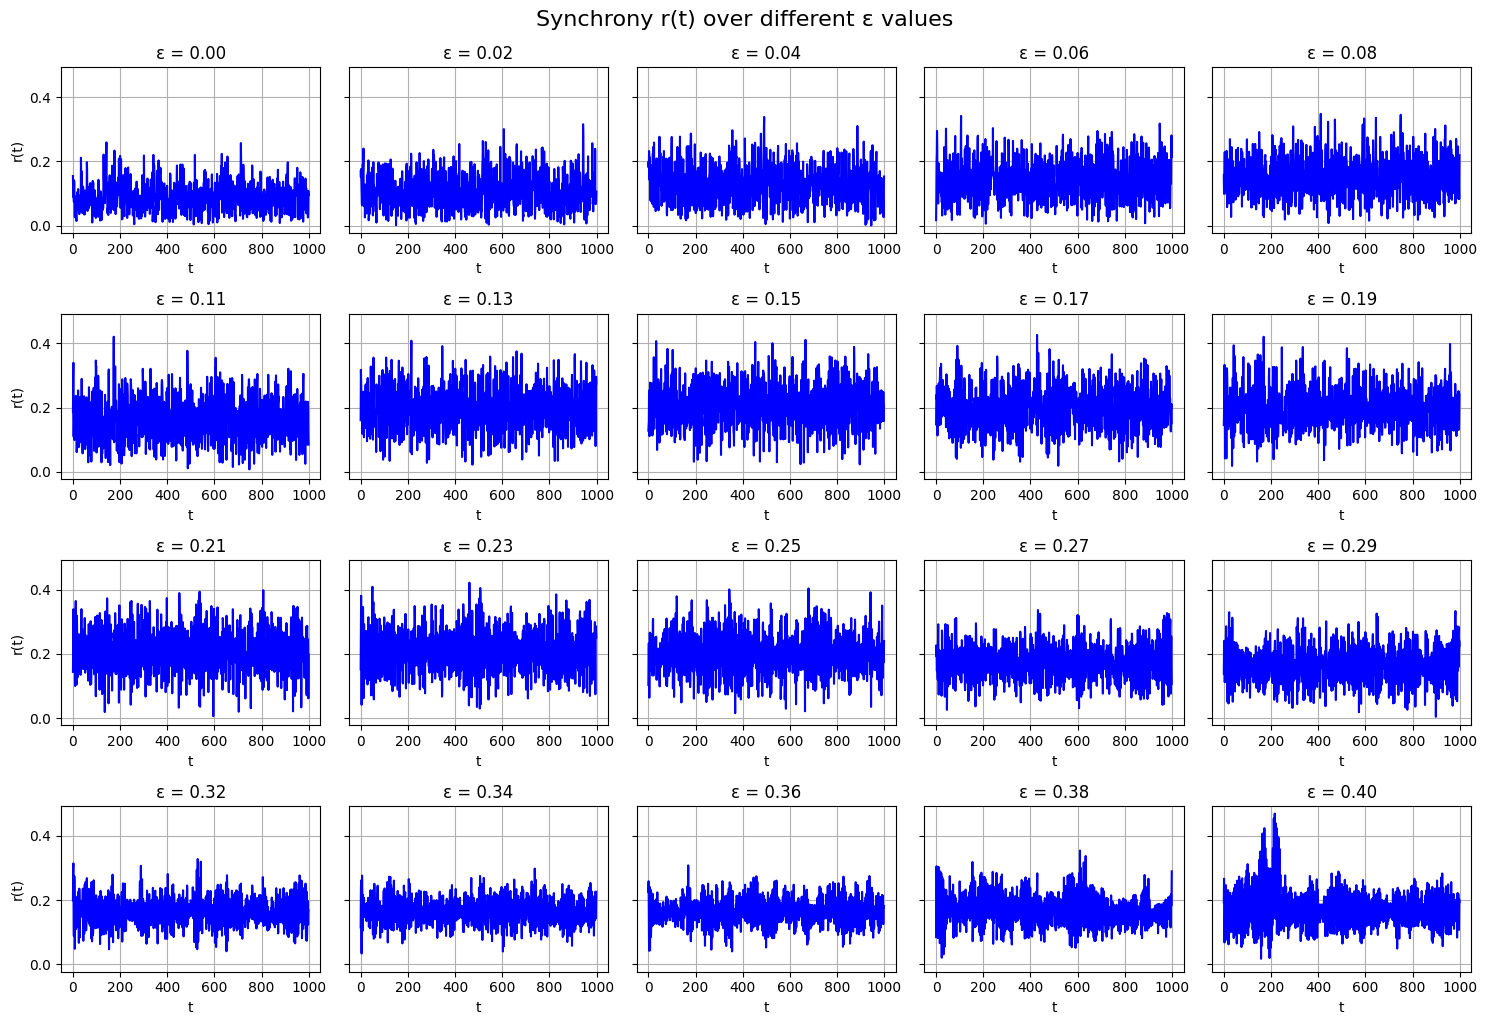

In [ ]:
epsilon_list3 = np.linspace(0, 0.4, 20)  # 15 epsilon values from 0 to 1
sweep_synchrony(epsilon_list3, N=100, T=1000)


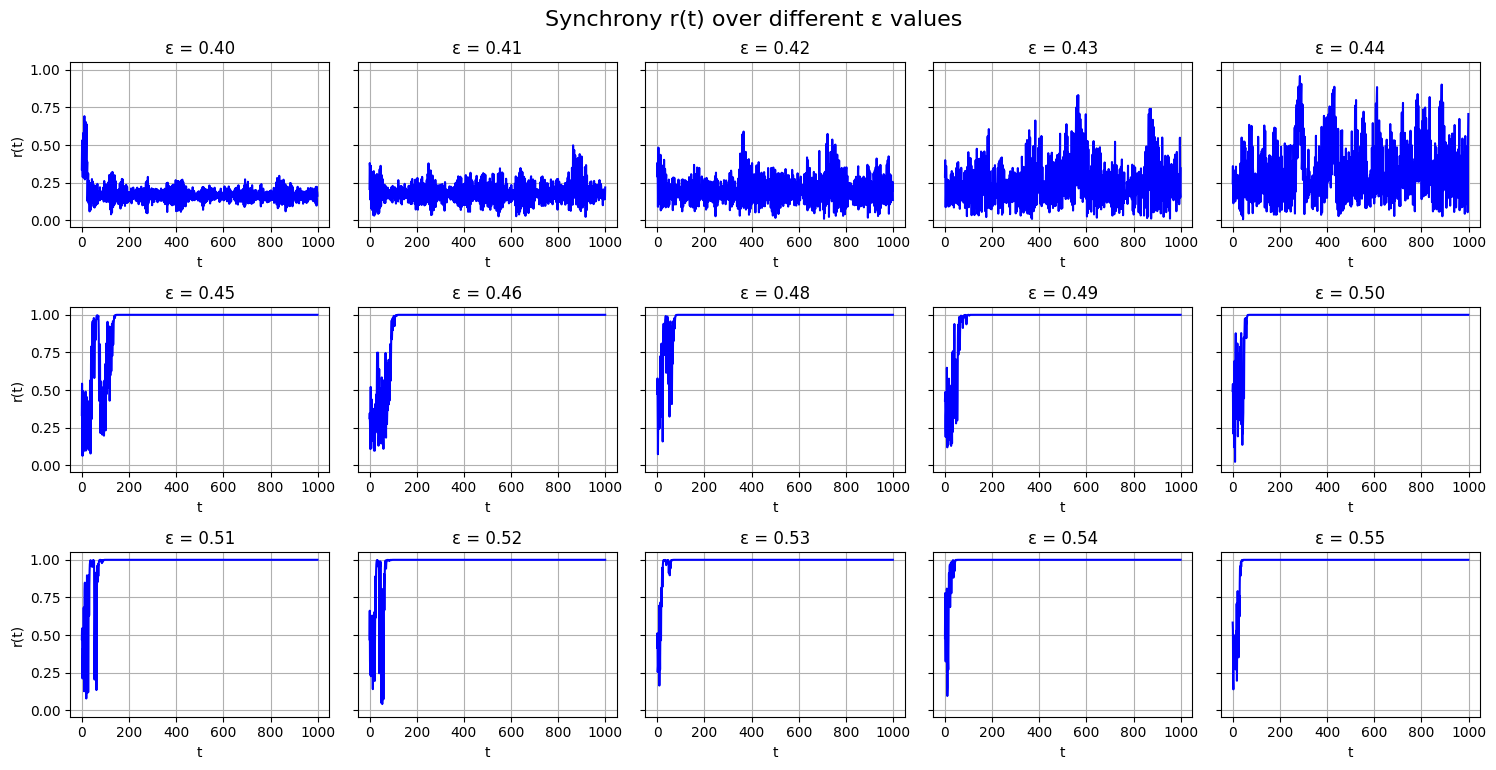

In [ ]:
epsilon_list2 = np.linspace(0.4, 0.55, 15)  # 15 epsilon values from 0 to 1
sweep_synchrony(epsilon_list2, N=100, T=1000)


In [ ]:

epsli = np.array([0.1313, 0.2373, 0.3686, 0.4242])
num_points = 5   # points before and after
step = 0.002     # spacing between points

arrays_around = []

for eps in epsli:
    local_range = np.linspace(eps - num_points * step, eps + num_points * step, 2 * num_points + 1)
    arrays_around.append(np.round(local_range, 6))

# Unpack into separate arrays
arr1, arr2, arr3, arr4 = arrays_around

print("Array around 0.1313:", arr1)
print("Array around 0.2373:", arr2)
print("Array around 0.3686:", arr3)
print("Array around 0.4242:", arr4)


Array around 0.1313: [0.1213 0.1233 0.1253 0.1273 0.1293 0.1313 0.1333 0.1353 0.1373 0.1393
 0.1413]
Array around 0.2373: [0.2273 0.2293 0.2313 0.2333 0.2353 0.2373 0.2393 0.2413 0.2433 0.2453
 0.2473]
Array around 0.3686: [0.3586 0.3606 0.3626 0.3646 0.3666 0.3686 0.3706 0.3726 0.3746 0.3766
 0.3786]
Array around 0.4242: [0.4142 0.4162 0.4182 0.4202 0.4222 0.4242 0.4262 0.4282 0.4302 0.4322
 0.4342]


In [ ]:
def compute_LE_single_map(b=4.0, T=100000, T_trans=5000, x0=0.12345):
    x = x0
    le_sum = 0.0

    for _ in range(T_trans):  # burn-in
        x = f_SB(x, b)

    for _ in range(T):
        derivative = df_SB(x, b)
        le_sum += np.log(np.abs(derivative))
        x = f_SB(x, b)

    return le_sum / T


In [ ]:

lambda_single = compute_LE_single_map(b=4.0)
print(f"Lyapunov exponent of f(x) alone : {lambda_single:.6f}")

Lyapunov exponent of f(x) alone : 0.562214


In [ ]:



def simulate_sb_gcm(N=100, T=5000, eps=0.15, b=3.0, seed=None):
    """
    Simulates a globally coupled skewed Bernoulli map (SB-GCM).

    Parameters:
    -----------
    N : int
        Number of nodes.
    T : int
        Number of time steps.
    eps : float
        Coupling strength (epsilon).
    b : float
        Skewness parameter for the Bernoulli map.
    seed : int or None
        Random seed for reproducibility.

    Returns:
    --------
    x_matrix : ndarray of shape (N, T)
        Time evolution of all node states.
    """

    if seed is not None:
        np.random.seed(seed)

    # Initialization
    x = np.random.rand(N)
    x_matrix = np.zeros((N, T))

    # Global (all-to-all) coupling matrix: uniform averaging
    W = np.ones((N, N)) / N

    # Time evolution
    for t in range(T):
        x_matrix[:, t] = x
        x_local = f_SB(x, b)
        x_coupled = W @ x_local  # Global mean field
        x = (1 - eps) * x_local + eps * x_coupled

    return x_matrix


In [ ]:
x_matrix = simulate_sb_gcm(N=100, T=5000, eps=0.2373, b=4.0, seed=42)


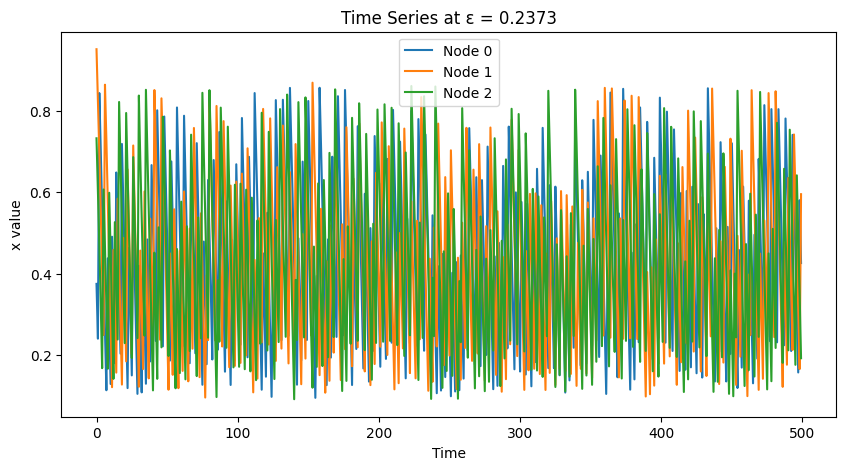

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(3):  # Plot for 3 nodes
    plt.plot(x_matrix[i, :500], label=f'Node {i}')
plt.xlabel('Time')
plt.ylabel('x value')
plt.title(f'Time Series at ε = {0.2373}')
plt.legend()
plt.show()


In [ ]:


# ------------------- Dynamics at Peak ε -------------------
def simulate_at_peak_epsilon(N=100, b=4.0, epsilon=0.056, T=1000, seed=0):
    np.random.seed(seed)
    y = np.random.rand(N)
    v = np.random.rand(N)
    v /= np.linalg.norm(v)

    trajectories = []
    for _ in range(T):
        y, v = evolve_system(y, v, epsilon, b)
        trajectories.append(y.copy())

    return np.array(trajectories)

# ------------------- Plot Dynamics -------------------
def plot_trajectories(traj, num_nodes_to_plot=10):
    T = traj.shape[0]
    x = np.arange(T)
    plt.figure(figsize=(10, 6))
    for i in range(num_nodes_to_plot):
        plt.plot(x, traj[:, i], label=f'Node {i}')
    plt.xlabel("Time")
    plt.ylabel("State y")
    plt.title("Trajectory of Sample Nodes")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------- Histogram Snapshot -------------------
def plot_state_histogram(traj, time_step=-1):
    y_snapshot = traj[time_step]
    plt.figure(figsize=(7, 4))
    plt.hist(y_snapshot, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel("State y")
    plt.ylabel("Frequency")
    plt.title(f"State Distribution at t = {time_step}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


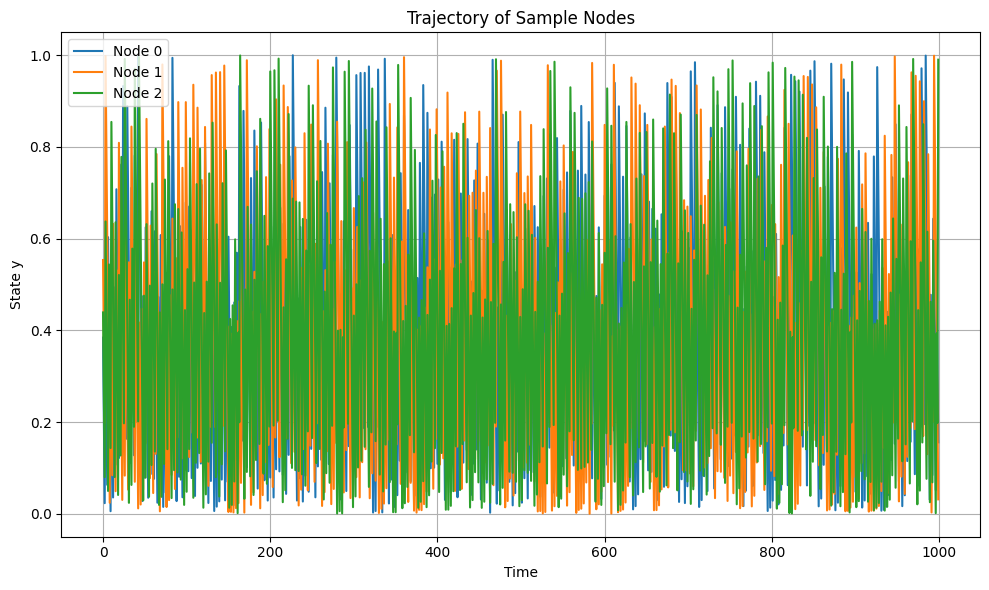

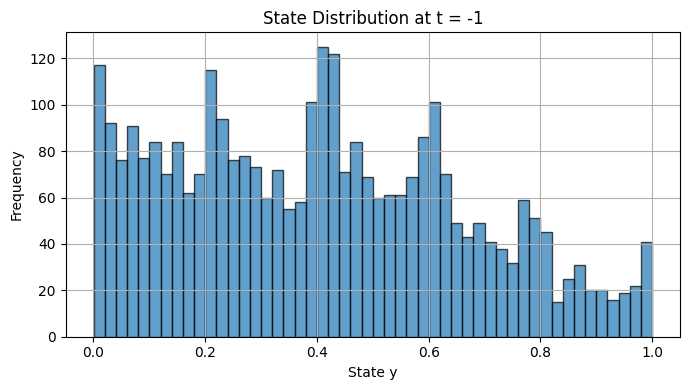

In [ ]:
# Simulate at peak epsilon
traj = simulate_at_peak_epsilon(N=3200, epsilon=0.2373)

# Plot node dynamics over time
plot_trajectories(traj, num_nodes_to_plot=3)

# Plot histogram snapshot at final time
plot_state_histogram(traj, time_step=-1)
